# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from DrTorch.metrics import F1_Score_Multi_Labels


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Wed Feb 21 16:53:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8               3W /  80W |     53MiB /  8188MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [15]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
display_utterance(dataframe=df, utterance_id='utterance_3491')
display_utterance(dataframe=df, utterance_id='utterance_456')
display_utterance(dataframe=df, utterance_id='utterance_2005')


Utterance 3491


,speakers,emotions,utterances,triggers
0,Phoebe,surprise,You-you you had sex with Ursula?!,0.0
1,Eric,fear,"Uh, a little bit. She-she-she walked in and I ...",0.0
2,Phoebe,surprise,You didn't notice she was wearing different cl...,1.0
3,Eric,sadness,Well I was just so excited to see you.,0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


In [20]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


In [21]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers
index,,,,
utterance_555,"[Phoebe, Phoebe]","[sadness, anger]","[Look, I feel really bad about how I freaked y...","[0.0, 0.0]"
utterance_3491,"[Phoebe, Eric, Phoebe, Eric]","[surprise, fear, surprise, sadness]","[You-you you had sex with Ursula?!, Uh, a litt...","[0.0, 0.0, 1.0, 0.0]"
utterance_527,"[Mona, Ross, Dr. Green, Ross]","[fear, neutral, anger, sadness]","[Oh my God! Oh my God! I'm so sorry!, Aw forge...","[0.0, 0.0, 1.0, 0.0]"
utterance_3925,"[Chandler, Chandler, Chandler, Chandler]","[neutral, neutral, neutral, disgust]","[I can blow dry it., I can put gel on it., It ...","[0.0, 0.0, 1.0, 0.0]"
utterance_2989,"[Ross, Phoebe, Ross]","[joy, joy, neutral]",[You're gonna love me so much. I got Sting tic...,"[0.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_3334,"[Rachel, Tag, Rachel]","[surprise, neutral, joy]","[Oh really?!, Yeah. Did you tell someone that ...","[0.0, 1.0, 0.0]"
utterance_652,"[Phoebe, Duncan, Phoebe, Duncan, Phoebe]","[neutral, surprise, joy, neutral, neutral]","[Hi., Phoebe!, Ta-da., Hey., Hi.]","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_172,"[Monica, Joey, Monica, Phoebe, Rachel, Joey, R...","[joy, surprise, anger, surprise, neutral, neut...","[Because we won our apartment back!, What? Ace...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3197,"[Older Scientist, Ross, Ross, Joey, Ross, Ross]","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_38,"[Chandler, Jade, Jade, Chandler]","[neutral, neutral, neutral, joy]","[What've you been up to?, Oh, you know, the us...","[0.0, 1.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_3881,"[Joey, Monica, Joey, All, Monica, Joey, Rachel...","[neutral, neutral, joy, disgust, disgust, sadn...","[Hey, y'know what a really good rainy day game...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2848,"[Janice, Chandler, Janice, Chandler, Janice, C...","[surprise, neutral, surprise, neutral, anger, ...","[Are you being British?!, No. Not anymore., Wh...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
utterance_1603,"[Rachel, Rachel, Rachel, Ross, Ross, Ross, Ros...","[sadness, sadness, sadness, neutral, neutral, ...",[I'm guess I'm just done with the whole dating...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_160,"[Mr. Tribbiani, Joey, Mr. Tribbiani, Joey]","[sadness, surprise, neutral, neutral]","[Gotta go. I miss you too, I love you, but it'...","[0.0, 0.0, 1.0, 0.0]"
utterance_1704,"[Rachel, Chandler, Rachel, Chandler, Rachel]","[joy, anger, neutral, sadness, surprise]","[Hi!, Another cheesecake came! They delivered ...","[0.0, 0.0, 0.0, 1.0, 0.0]"


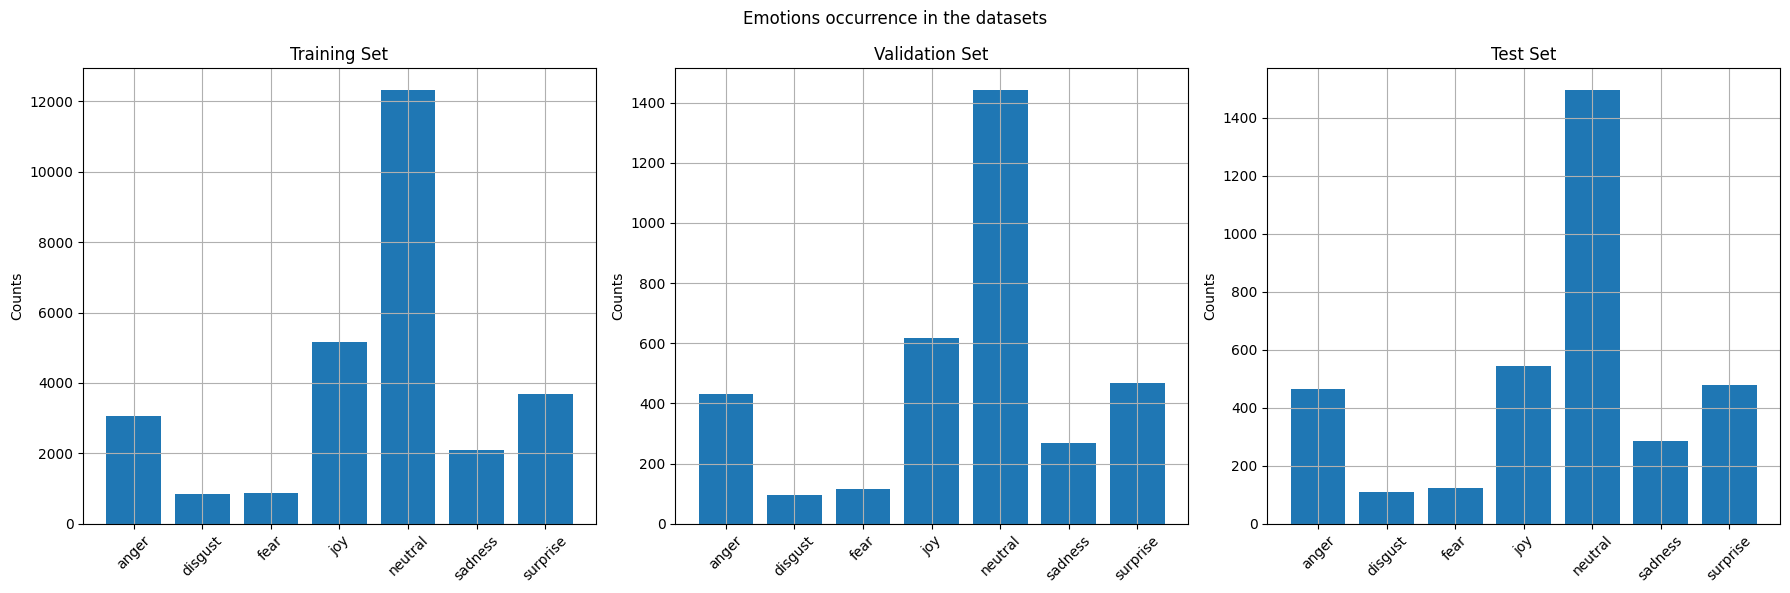

In [22]:
plot_emotion_distribution(train_df, val_df, test_df)


## Random Classifier

In [26]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_utterance(dataframe=new_test_df, utterance_id='utterance_3881')
    

Utterance 3881


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,"Hey, y'know what a really good rainy day game is?",0.0,anger,1
1,Monica,neutral,What?!,0.0,neutral,1
2,Joey,joy,"I mean naked game. Strip poker, we should tota...",0.0,disgust,1
3,All,disgust,"No, no!",0.0,neutral,1
4,Monica,disgust,What are you crazy?!,0.0,sadness,1
5,Joey,sadness,"Come on! When you go away, you-you have to pla...",0.0,surprise,0
6,Rachel,neutral,Allll done!,0.0,neutral,0
7,Monica,joy,"Aww, thank you.",0.0,surprise,0
8,Rachel,neutral,"Okay, who's next?!",0.0,disgust,0
9,Ross,disgust,No-o-o! No way!,0.0,sadness,1


## Majority Classifier

In [11]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_utterance(dataframe=new_test_df, utterance_id='utterance_3881')



Utterance 3881


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,"Hey, y'know what a really good rainy day game is?",0.0,neutral,0.0
1,Monica,neutral,What?!,0.0,neutral,0.0
2,Joey,joy,"I mean naked game. Strip poker, we should tota...",0.0,neutral,0.0
3,All,disgust,"No, no!",0.0,neutral,0.0
4,Monica,disgust,What are you crazy?!,0.0,neutral,0.0
5,Joey,sadness,"Come on! When you go away, you-you have to pla...",0.0,neutral,0.0
6,Rachel,neutral,Allll done!,0.0,neutral,0.0
7,Monica,joy,"Aww, thank you.",0.0,neutral,0.0
8,Rachel,neutral,"Okay, who's next?!",0.0,neutral,0.0
9,Ross,disgust,No-o-o! No way!,0.0,neutral,0.0


## Bert Models

In [19]:
# todo Bert Models
# todo capire come fare l'encoding di frasi e SOPRATTUTTO emotions

# Mauro fa schifo ihihih

['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral'] [0, 0, 0, 0, 0, 0, 0]


,episode,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
3600,utterance_2664,"[Phoebe, The Lurker, Phoebe, The Lurker, The S...","[surprise, anger, anger, anger, neutral, disgu...","[I won! I won! I finally won!, I won! That was...","[0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0]"
3601,utterance_3741,"[Rachel, Rachel, Ross, Rachel, Ross, Rachel]","[neutral, neutral, neutral, joy, neutral, neut...","[Bye-bye Julie., Hey., Hey., Hey, c'mon, cut i...","[0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0]"
3602,utterance_2895,"[Rachel, Rachel, Rachel, Rachel, Stranger, Rac...","[sadness, sadness, fear, neutral, neutral, joy...","[Mom, would you relax., That was 10 blocks fro...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3603,utterance_3090,"[Elizabeth, Ross, Elizabeth, Ross]","[joy, surprise, neutral, neutral]",[Oh please! It was such a big class! You never...,"[0, 0, 0, 0]","[neutral, neutral, neutral, neutral]","[0, 0, 0, 0]"
3604,utterance_393,"[Joey, Chandler, Joey, Chandler, Joey, Chandle...","[joy, fear, joy, neutral, surprise, fear, fear...","[Wow thanks!, Joe?, Yeah!, Uh, you've had a lo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
3995,utterance_1136,"[Phoebe, Chandler, Monica, Chandler, Joey, Cha...","[neutral, neutral, neutral, neutral, neutral, ...","[Which you just gave up really quickly., Have ...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3996,utterance_79,"[Rachel, Joey, Phoebe, Joey, Joey, Joey, Joey,...","[neutral, joy, joy, joy, joy, joy, joy, joy, n...","[How did it go with Erin?, Oh, unbelievable! W...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3997,utterance_3470,"[Ross, Mona, Ross, Ross, Mona, Ross, Ross]","[joy, neutral, joy, joy, neutral, neutral, joy]","[Here we go. Mona umm, I think it's time we-we...","[0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0]"
3998,utterance_377,"[Monica, Chandler, Phoebe, Monica, Phoebe, Rac...","[neutral, disgust, anger, joy, joy, sadness, s...","[Okay, I've got some Ones, you wanna put them ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[neutral, neutral, neutral, neutral, neutral, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


KeyError: '3600'

In [3]:
from typing import Callable, Optional, Dict
import torch
x = {'head1': {'metric_constructor': 'f1',
               'name': 'emotion_f1',
               'mode': 'mean',
               'class_to_exclude': [1, 2, 3],
               'num_classes': 8
               },
     'head2': {'metric_constructor': 'f1',
               'name': 'trigger_f1',
               'mode': 'mean',
               'class_to_exclude': [1, 2, 3],
               'num_classes': 2
               }
         }




    


dict_items([('head_1', {'criterion': 'criterio_1 instaziato', 'weight': 1}), ('head_2', {'criterion': 'criterio_2 instaziato', 'weight': 1}), ('reduction_function', <built-in method mean of type object at 0x7eff57cdd8a0>)])


In [7]:
my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Indicizzazione degli elementi e stampa
for idx in range(3):
    for new_idx in range(3):
        crt_idx = idx * 3 + new_idx
        print(f"Elemento alla posizione ({idx}, {new_idx}): {my_list[crt_idx]}")

Elemento alla posizione (0, 0): 1
Elemento alla posizione (0, 1): 2
Elemento alla posizione (0, 2): 3
Elemento alla posizione (1, 0): 4
Elemento alla posizione (1, 1): 5
Elemento alla posizione (1, 2): 6
Elemento alla posizione (2, 0): 7
Elemento alla posizione (2, 1): 8
Elemento alla posizione (2, 2): 9
